In [1]:
import glob
import numpy as np
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import pickle

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
glob.glob('drive/MyDrive/BDML/assets/haarcascade_frontalface_default.xml')

['drive/MyDrive/BDML/assets/haarcascade_frontalface_default.xml']

In [5]:
for e in glob.glob("/content/drive/MyDrive/BDML/drowsiness-dataset/*/*"):
    parts = e.split("/")
    print(parts)
    break

['', 'content', 'drive', 'MyDrive', 'BDML', 'drowsiness-dataset', 'drowsy', '11_.jpg']


In [6]:
def standarize(e):
    try: 
        parts = e.split("/")
        img = cv2.imread(e)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img, parts[6], e
    except Exception as err:
        print(f"Can not load image {e}")
        return None

In [ ]:
X_prev = np.array([standarize(e) for e in glob.glob("/content/drive/MyDrive/BDML/drowsiness-dataset/*/*")])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
print(X_prev.shape)

(2797, 3)


In [ ]:
X_prev[0]

array([array([[[49, 34, 41],
               [49, 34, 41],
               [49, 34, 41],
               ...,
               [89, 69, 81],
               [89, 69, 81],
               [89, 69, 81]],

              [[49, 34, 41],
               [49, 34, 41],
               [49, 34, 41],
               ...,
               [91, 71, 83],
               [91, 71, 83],
               [91, 71, 83]],

              [[49, 34, 41],
               [49, 34, 41],
               [49, 34, 41],
               ...,
               [96, 76, 88],
               [96, 76, 88],
               [96, 76, 88]],

              ...,

              [[27, 18, 19],
               [27, 18, 19],
               [27, 18, 19],
               ...,
               [92, 73, 77],
               [90, 71, 75],
               [89, 70, 74]],

              [[27, 18, 19],
               [27, 18, 19],
               [27, 18, 19],
               ...,
               [88, 69, 73],
               [85, 66, 70],
               [83, 64, 68]],



In [ ]:
ind = np.random.choice(X_prev.shape[0],10)

In [ ]:
labels = ["alert",
          "drowsy",
          "no_yawn",
          "yawn"
          ]

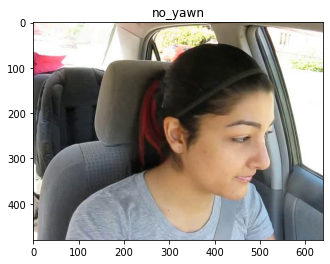

In [ ]:
X = X_prev[...,0] # imagen
y = X_prev[...,1] # label
filenames = X_prev[...,2] # path
plt.title(y[1490]) # titulo
plt.imshow(X[1490]) # imagen

## Gray scale

In [ ]:
X_bw = list(map(lambda im:cv2.cvtColor(im, cv2.COLOR_RGB2GRAY), X))

## Save X_prev

In [ ]:
obj = X_prev
with open("X_prev.pickle", "wb") as f:
    pickle.dump(obj, f)

In [ ]:
with open("X_prev.pickle", "rb") as f:
    X_prev = pickle.load(f)
print(X_prev[0])

## Save bw images

In [ ]:

# Guardar la lista X_bw en el archivo "obj.pickle".
obj = X_bw
with open("bw_images.pickle", "wb") as f:
    pickle.dump(obj, f)

In [ ]:
# Abre el archivo donde guarde las imagenes procesadas a blanco y negro
with open("bw_images.pickle", "rb") as f:
    obj = pickle.load(f)
print(obj)

In [ ]:
obj[0]

array([[39, 39, 39, ..., 76, 76, 76],
       [39, 39, 39, ..., 78, 78, 78],
       [39, 39, 39, ..., 83, 83, 83],
       ...,
       [21, 21, 21, ..., 79, 77, 76],
       [21, 21, 21, ..., 75, 72, 70],
       [21, 21, 21, ..., 73, 69, 67]], dtype=uint8)

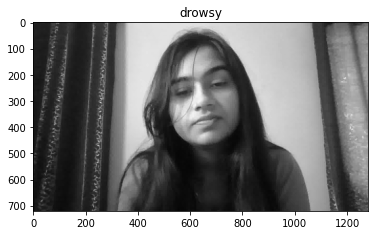

In [ ]:
plt.title(y[0]) # titulo
plt.imshow(X_bw[0], cmap="gray") # imagen bw

In [ ]:
print(X_bw[1].shape, X[1].shape)

(720, 1280) (720, 1280, 3)


## For yawn and not_yawn. Take only face

In [7]:
def face_for_yawn(direc="drive/MyDrive/BDML/drowsiness-dataset/", face_cas_path='drive/MyDrive/BDML/assets/haarcascade_frontalface_default.xml'):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For alert and drowsy. Take only face

In [8]:
def face_for_drowsy(direc="drive/MyDrive/BDML/drowsiness-dataset/", face_cas_path='drive/MyDrive/BDML/assets/haarcascade_frontalface_default.xml'):
    drowsy_no = []
    IMG_SIZE = 145
    categories = ["drowsy", "alert"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        class_num1 +=2
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                drowsy_no.append([resized_array, class_num1])
    return drowsy_no


data_train = face_for_drowsy()

2
3


## Extend data and convert array

In [9]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = face_for_drowsy()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [10]:
new_data = append_data()

0
1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


## Separate label and features

In [11]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the array

In [12]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [13]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [14]:
y = np.array(y)

## train test split

In [15]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [16]:
print(len(X_train),len(y_test))

1407 604


## Data Augmentation

In [17]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## Model

In [18]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

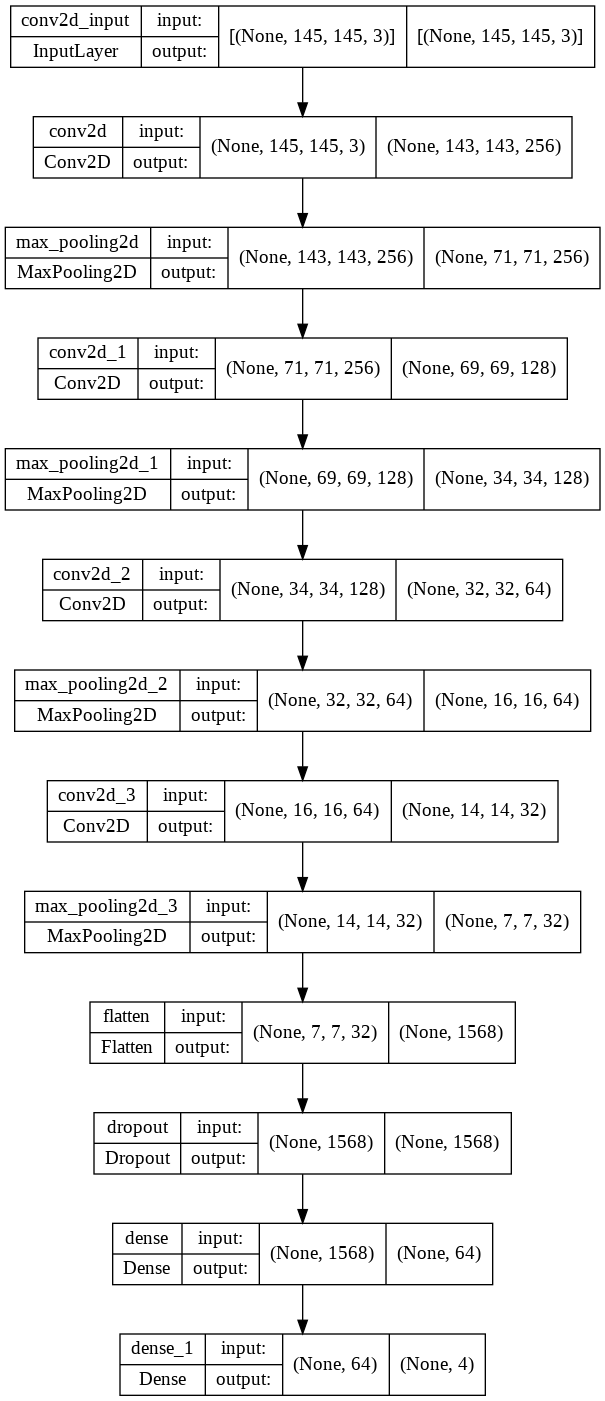

In [19]:
plot_model(model,show_shapes=True)

In [20]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
44/44 [==============================] - 25s 318ms/step - loss: 1.1883 - accuracy: 0.4812 - val_loss: 0.9665 - val_accuracy: 0.6026
Epoch 2/50
44/44 [==============================] - 12s 267ms/step - loss: 0.7399 - accuracy: 0.7385 - val_loss: 0.4012 - val_accuracy: 0.8791
Epoch 3/50
44/44 [==============================] - 12s 268ms/step - loss: 0.4937 - accuracy: 0.8472 - val_loss: 0.4667 - val_accuracy: 0.8725
Epoch 4/50
44/44 [==============================] - 12s 269ms/step - loss: 0.4372 - accuracy: 0.8564 - val_loss: 0.3643 - val_accuracy: 0.8841
Epoch 5/50
44/44 [==============================] - 12s 268ms/step - loss: 0.3711 - accuracy: 0.8756 - val_loss: 0.3030 - val_accuracy: 0.8924
Epoch 6/50
44/44 [==============================] - 12s 269ms/step - loss: 0.4233 - accuracy: 0.8628 - val_loss: 0.3378 - val_accuracy: 0.8990
Epoch 7/50
44/44 [==============================] - 12s 267ms/step - loss: 0.3564 - accuracy: 0.8699 - val_loss: 0.2786 - val_accuracy: 0.8974

## History

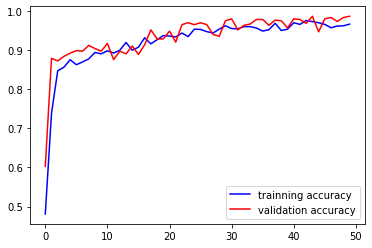

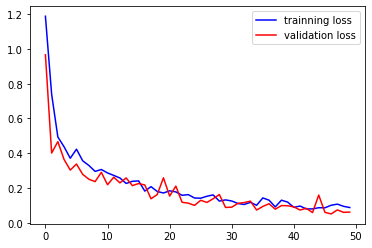

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save model

In [22]:
model.save("drive/MyDrive/drowiness_train.h5")

## Prediction

In [32]:
prediction = np.argmax(model.predict(X_test), axis=-1)
prediction

array([3, 2, 1, 3, 1, 2, 2, 1, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 1, 2, 0,
       2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 0, 2, 3, 2, 1, 0, 2, 2, 3, 1, 1, 2,
       2, 1, 3, 1, 3, 3, 3, 2, 3, 2, 3, 2, 1, 1, 2, 3, 0, 2, 3, 3, 3, 1,
       3, 2, 0, 1, 3, 2, 2, 2, 2, 3, 3, 3, 3, 1, 3, 2, 3, 3, 2, 0, 3, 2,
       2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 0, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 1, 2, 1, 3, 2, 1, 3, 3, 1, 2, 2, 3, 3, 0,
       0, 3, 2, 3, 2, 3, 3, 2, 2, 1, 3, 3, 2, 1, 2, 3, 3, 2, 3, 2, 3, 3,
       2, 0, 0, 2, 2, 3, 3, 0, 3, 1, 1, 3, 1, 1, 2, 0, 2, 2, 3, 0, 3, 3,
       2, 0, 2, 2, 2, 1, 1, 3, 3, 1, 3, 1, 3, 2, 0, 2, 3, 3, 0, 1, 1, 0,
       2, 2, 3, 2, 0, 2, 3, 3, 3, 3, 3, 3, 0, 1, 3, 1, 0, 2, 3, 2, 0, 2,
       0, 3, 0, 2, 3, 3, 3, 3, 2, 2, 0, 1, 2, 2, 1, 1, 1, 3, 3, 3, 0, 1,
       3, 3, 2, 3, 1, 2, 3, 3, 2, 1, 2, 2, 3, 0, 3, 2, 2, 3, 2, 2, 3, 3,
       0, 3, 0, 2, 3, 1, 3, 0, 0, 3, 2, 2, 2, 3, 3, 1, 2, 2, 3, 0, 3, 2,
       3, 1, 1, 0, 3, 1, 0, 0, 3, 3, 2, 3, 2, 3, 0,

## Classification Report

In [33]:
labels_new = ["yawn", "no_yawn", "Alert", "Drowsy"]

In [34]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.91      0.91      0.91        66
     no_yawn       0.87      0.99      0.92        81
       Alert       0.98      0.99      0.98       190
      Drowsy       1.00      0.95      0.97       267

    accuracy                           0.96       604
   macro avg       0.94      0.96      0.95       604
weighted avg       0.96      0.96      0.96       604



## Predicting function

In [35]:
IMG_SIZE = 145
def prepare(filepath, face_cas="drive/MyDrive/BDML/assets/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("drive/MyDrive/drowiness_train.h5")

## Prediction
0-yawn, 1-no_yawn, alert, drowsy

In [57]:
prediction = model.predict([prepare('drive/MyDrive/test/10.jpg')])
np.argmax(prediction)

0

In [64]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

DisabledFunctionError: ignored

In [ ]:
face_cascade = cv2.CascadeClassifier('drive/MyDrive/BDML/assets/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(X_bw[1], 1.3,5)

## Convert coordinates

[]

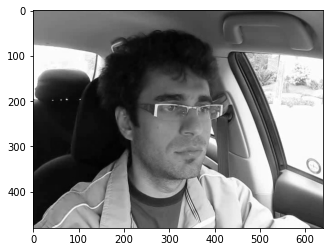

In [ ]:
def rect(face):
    x,y,w,h = face
    return [
        [x,x+w,x+w,x,x],
        [y,y,y+h,y+h,y]
    ]
plt.imshow(X_bw[1], cmap="gray")
[plt.plot(*rect(face), c = "r") for face in faces]

## Detect Faces

In [ ]:
def dectect_faces(im):
    faces = face_cascade.detectMultiScale(im, 1.3,5)
    plt.imshow(im, cmap="gray")
    [plt.plot(*rect(faces[0]), c = "r") for face in faces] 

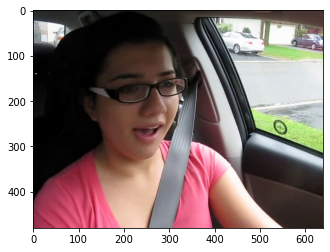

In [ ]:
im_test = np.random.choice(X)
dectect_faces(im_test)